In [1]:
import tensorflow as tf
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #suppress logging messages
tf.logging.set_verbosity(tf.logging.ERROR) #suppress logging messages
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format 
#whatever the value and .1f tells to format it upto one decimal place

In [60]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

0        66900.0
1        80100.0
2        85700.0
3        73400.0
4        65500.0
          ...   
16995   111400.0
16996    79000.0
16997   103600.0
16998    85800.0
16999    94600.0
Name: median_house_value, Length: 17000, dtype: float64


In [61]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0

11002   290500.0
3867     55000.0
3129    212900.0
14693   157500.0
14599   356000.0
          ...   
4854    103500.0
7175    235500.0
5460    142800.0
11237   164000.0
5196    213200.0
Name: median_house_value, Length: 17000, dtype: float64
After dividing by 1000:  11002   290.5
3867     55.0
3129    212.9
14693   157.5
14599   356.0
         ... 
4854    103.5
7175    235.5
5460    142.8
11237   164.0
5196    213.2
Name: median_house_value, Length: 17000, dtype: float64


In [62]:
def input_function(features,targets,batch_size=1,num_epochs=None,shuffle=True):
    
    # Convert pandas data into a dict of np arrays
	features = {key:np.array(value) for key, value in dict(features).items()}

	# Construct a dataset API (tensorflow), and configure batching/repeating
	ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
	ds = ds.batch(batch_size).repeat(num_epochs)

    #shuffle the data, if specified
	if shuffle:
		ds = ds.shuffle(buffer_size= 10000)

    #Return the next batch of data
	features,labels = ds.make_one_shot_iterator().get_next()
	return features,labels

In [63]:
def train_model(learning_rate,steps,batch_size,input_feature):
    
    """Trains a linear regression model.
  
      Args:
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        input_feature: A `string` specifying a column from `california_housing_dataframe`
          to use as input feature.
      
      Returns:
        A Pandas `DataFrame` containing targets and the corresponding predictions done
        after training the model.
    """    
    periods = 10
    step_period = steps/periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    #astype gives all data the same type
    my_label = "median_house_value"
    target_data = california_housing_dataframe[my_label].astype('float32')
    
    #Create feature column
    feature_column = [tf.feature_column.numeric_column(my_feature)]
    
    #Create input functions for training and predicitons
    training_input = lambda:input_function(my_feature_data,target_data,batch_size=batch_size)
    prediction_input = lambda:input_function(my_feature_data, target_data,num_epochs=1,shuffle=False)
    
    #Optimizer
    opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    opt = tf.contrib.estimator.clip_gradients_by_norm(opt,5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_column,
                                                   optimizer = opt)
    
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label]) #dot plotter on graph
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
     # Train the model, but do so inside a loop so that we can periodically assess
     # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range(0,periods):
        linear_regressor.train(input_fn = training_input, steps=step_period)
        predictions = linear_regressor.predict(input_fn=prediction_input)
        predictions = np.array([item['predictions'][0] for item in predictions])
        #loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions,target_data))
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        
        #weights and biases with line plots
        y_extents = np.array([0, sample[my_label].max()])
    
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
    
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,sample[my_feature].max()),sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print ("Model trining finished.")
    
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    #Create a table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data["targets"] = pd.Series(target_data)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" %root_mean_squared_error)
    return calibration_data

In [64]:
#synthtic input feature
california_housing_dataframe["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])

11002   290.5
3867     55.0
3129    212.9
14693   157.5
14599   356.0
         ... 
4854    103.5
7175    235.5
5460    142.8
11237   164.0
5196    213.2
Name: median_house_value, Length: 17000, dtype: float32
Training model...
RMSE (on training data):
[44.747036 26.986233 27.029472 ... 19.7423   30.908016 26.756058]
  period 00 : 212.75
[89.50708  53.980206 54.066696 ... 39.49019  61.824936 53.519783]
  period 01 : 189.65
[132.66188   80.215866  80.343544 ...  58.825195  91.79653   79.53617 ]
  period 02 : 169.49
[172.92505  104.90931  105.07489  ...  77.168365 119.92794  104.02784 ]
  period 03 : 153.32
[209.85826 127.67702 127.87709 ...  94.15851 145.82355 126.61195]
  period 04 : 141.60
[242.8505   147.80467  148.03607  ... 109.039215 168.79185  146.5729  ]
  period 05 : 134.55
[270.31137 164.89859 165.15523 ... 121.90486 188.17491 163.53247]
  period 06 : 131.21
[292.43988 178.60645 178.88358 ... 132.17828 203.74214 177.1312 ]
  period 07 : 130.54
[307.2616  187.92923 188.21976 ..

,predictions,targets
count,17000.0,17000.0
mean,194.6,207.3
std,88.7,116.0
min,45.7,15.0
25%,159.8,119.4
50%,191.6,180.4
75%,218.6,265.0
max,4233.1,500.0


Final RMSE (on training data): 131.23


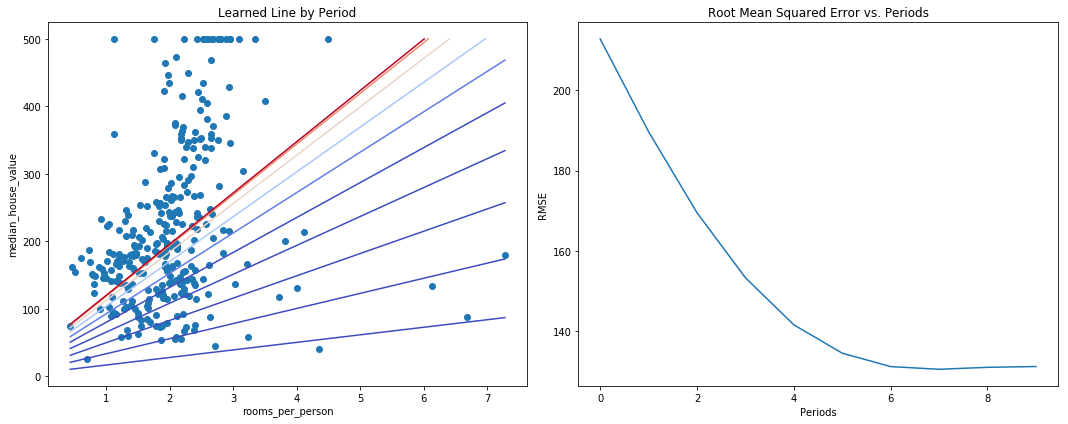

In [65]:
calibration_data = train_model(learning_rate=0.05,steps=500, batch_size=5, input_feature="rooms_per_person")


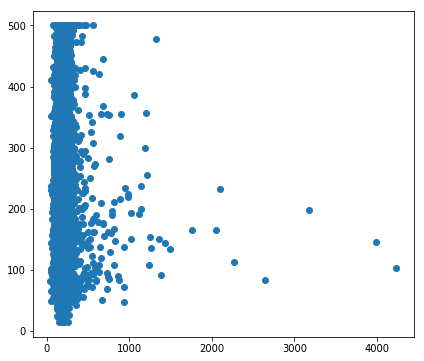

In [66]:
#identify outlier
#step 1: draw scatter plot of predictions and target_values using synthetic feature
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(calibration_data["predictions"], calibration_data["targets"])


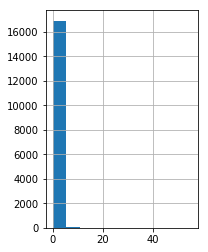

In [67]:
plt.subplot(1, 2, 2)
_ = california_housing_dataframe["rooms_per_person"].hist()

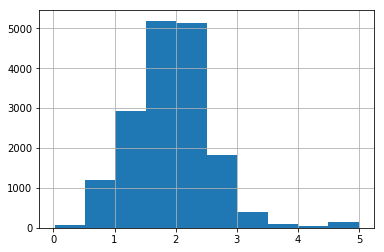

In [68]:
#clipping outliers by lambda function
california_housing_dataframe["rooms_per_person"] = (california_housing_dataframe["rooms_per_person"]).apply(lambda x: min(x, 5))
_ = california_housing_dataframe["rooms_per_person"].hist()

11002   290.5
3867     55.0
3129    212.9
14693   157.5
14599   356.0
         ... 
4854    103.5
7175    235.5
5460    142.8
11237   164.0
5196    213.2
Name: median_house_value, Length: 17000, dtype: float32
Training model...
RMSE (on training data):
[44.608772 26.992163 27.035051 ... 19.807041 30.882107 26.763855]
  period 00 : 212.82
[89.2966   53.967556 54.053566 ... 39.55823  61.768604 53.5097  ]
  period 01 : 189.08
[133.92102   80.95222   81.08118  ...  59.348328  92.64832   80.265755]
  period 02 : 166.72
[176.66484  106.89224  107.0621   ...  78.434746 122.29881  105.98801 ]
  period 03 : 147.13
[215.54861  130.61674  130.8235   ...  95.976364 149.37065  129.51604 ]
  period 04 : 131.56
[246.79422 149.66324 149.89972 ... 110.04733 171.11084 148.40445]
  period 05 : 121.29
[267.7697  162.68945 162.94527 ... 119.83134 185.89233 161.32764]
  period 06 : 115.71
[281.119   171.14288 171.41064 ... 126.28798 195.42685 169.71762]
  period 07 : 112.82
[291.3328  177.50507 177.78218 ..

,predictions,targets
count,17000.0,17000.0
mean,190.5,207.3
std,49.8,116.0
min,44.5,15.0
25%,158.7,119.4
50%,190.5,180.4
75%,217.6,265.0
max,422.7,500.0


Final RMSE (on training data): 108.80


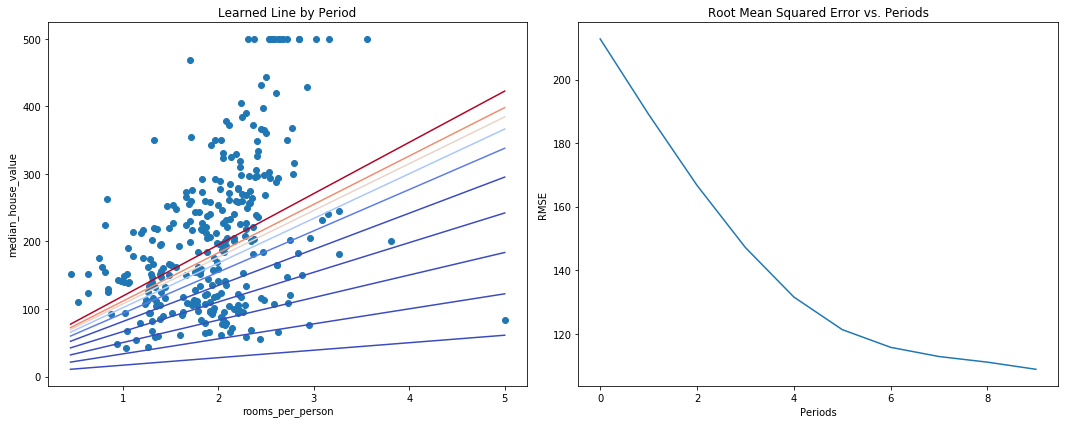

In [69]:
#to test whether clipping worked or not
calibration_data = train_model(learning_rate=0.05, steps=500, batch_size=5, input_feature="rooms_per_person")

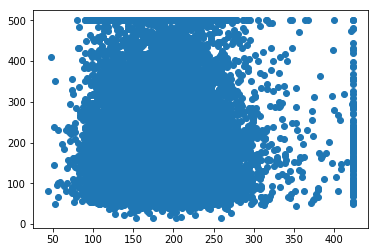

In [70]:
_ = plt.scatter(calibration_data["predictions"], calibration_data["targets"])